# Non linear phase inversion with minopyApp #

[MiNoPy](https://github.com/geodesymiami/MiNoPy/tree/AugModifications) is an open source python package of InSAR processing with Non Linear phase inversion in full resolution. It reads a stack of coregistered SLCs and produces time series of surface deformation by jointly inverting for persistent and distributed scatterers (PS and DS). This Package works with [MintPy](https://github.com/insarlab/MintPy) and different correction steps after phase inversion are perfomed with MintPy. 
In this notebook, we describe different steps and available options in MiNoPy python package.

Details about the algorithms can be found at:
+ S. Mirzaee, F. Amelung, H. Fattahi, Non-linear phase inversion using joined distributed And Persistent Scatterers. (in prep)


# general overview #

The time series analysis workflow in minopyApp consists of 8 steps which will be explained one by one through an example dataset.

###  Example data:
The example data we use here is a stack of Sentinel-1 images in descending track 142 acquired over Guagua Pichincha volcano, Ecuador ([Zenodo](https://zenodo.org/record/5167298/files/PichinchaSenDT142.zip); ~318M in size). It spans from 2016.04.19 to 2017.12.28 with 46 acquisitions in total. We use the stack Sentinel processor ([Fattahi et al., 2016](https://ieeexplore.ieee.org/document/7637021)) within ISCE ([Rosen et al., 2012](https://ieeexplore.ieee.org/document/6217174/authors#authors)) for coregistering the SAR stack.

## 0. Initial setup of the notebook ##

The cell below performs the intial setup of the notebook and **must be run every time the notebook (re)starts**. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [65]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mintpy.objects import ifgramStack
from mintpy.utils import plot as pp, utils as ut
from mintpy import view, plot_network

# define work directory
work_dir = os.path.expanduser('~/data/test')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download example dataset
url = 'https://zenodo.org/record/5167298/files/PichinchaSenDT142.zip'
zip_file = os.path.basename(url)
proj_name = zip_file.split('.')[0]
if not os.path.isfile(zip_file):
    !wget {url}
else:
    print('{} exists, skip re-download.'.format(zip_file))

# uncompress example dataset
if not os.path.isdir(proj_name):
    print('uncompressing the zip file ...')
    !unzip -q {zip_file}

# go to project directory
proj_dir = os.path.join(work_dir, proj_name)
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

Go to work directory: /Users/Sara/data/test
PichinchaSenDT142.zip exists, skip re-download.
Go to project directory: /Users/Sara/data/test/PichinchaSenDT142


## 1. Setting up template file ##

The configuration parameters to minopyApp.py are controlled through three template files. At least one template is required to run minopyApp.py.    

+ `default template`: [minopyApp.cfg](https://github.com/geodesymiami/MiNoPy/blob/AugModifications/minopy/defaults/minopyApp.cfg). It contains all MiNoPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [minopyApp_auto.cfg](https://github.com/geodesymiami/MiNoPy/blob/AugModifications/minopy/defaults/minopyApp_auto.cfg)). This file is copied over to the current working directory and read every time minopyApp.py runs.


+ `default template`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). It contains all MintPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.


+ `custom template` (optional but recommended): PichinchaSenDT142.template in the example dataset. It contains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the two default templates; if custom template is input, minopyApp.py will update the default minopyApp.cfg and smallbaselineApp.cfg files accordingly.  

### Custom template example ###

The path of all input files (`minopy.load.*`), subset area (`minopy.subset.*`) and the reference point (`mintpy.reference.*`) are always recommended. Below are from PichinchaSenDT142.template file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_slc.py -H to check more details and example inputs.

minopy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isceTops
minopy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
minopy.load.compression    = auto  #[gzip / lzf / no], auto for no.
minopy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:        
minopy.load.slcFile        = ../merged/SLC/*/*.slc.full  #[path2slc_file]
##---------for ISCE only:
minopy.load.metaFile       = ../reference/IW*.xml
minopy.load.baselineDir    = ../baselines
##---------geometry datasets:
minopy.load.demFile          = ../merged/geom_reference/hgt.rdr.full
minopy.load.lookupYFile      = ../merged/geom_reference/lat.rdr.full
minopy.load.lookupXFile      = ../merged/geom_reference/lon.rdr.full
minopy.load.incAngleFile     = ../merged/geom_reference/los.rdr.full
minopy.load.azAngleFile      = ../merged/geom_reference/los.rdr.full
minopy.load.shadowMaskFile   = ../merged/geom_reference/shadowMask.rdr.full
minopy.load.waterMaskFile    = None
##---------interferogram datasets:
minopy.load.unwFile        = ./inverted/interferograms_single_reference/*/*fine*.unw
minopy.load.corFile        = ./inverted/interferograms_single_reference/*/*fine*.cor
minopy.load.connCompFile   = ./inverted/interferograms_single_reference/*/*.unw.conncomp
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
minopy.subset.lalo         = -0.199:-0.142,-78.612:-78.578
# Reference point
mintpy.reference.lalo     = -0.1792, -78.5905

```
    
Run **load_slc.py -H** for example input file paths for ISCE, GAMMA and ROI_PAC.  

There are two sets of options for **MiNoPy (minopyApp.cfg)** starting with `minopy.*` and for **MintPy (smallbaselineApp.cfg)** starting with `mintpy.*`

Run **minopyApp.py -H** for a complete list of options you can use and add to your custom template file.


### Using Docker/Singularity ###

There is `minopy.textCmd` options on top of default `minopyApp.cfg` template file which you may want to set them if you need to run a specific command before everything. For example if you use docker, you need to run commands like this:
```
docker run {your command}
docker run minopyApp.py -h
```
Then you should set:
```
minopy.textCmd   =  docker run
```
### Parallel processing ###

If you want to run tasks in parallel, then you can set the number of workers/cores per node with `minopy.compute.numWorker` option. The default is set to 4 for a personal computer with 4 CPUs.

## 2. minopyApp.py processing steps ##

The minopyApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. 
If you work on HPC, you can create jobs for each step and run them one by one
More detailed usage can be found in help. 

In [42]:
!minopyApp.py --help

usage: minopyApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--walltime WALL_TIME] [--queue QUEUE] [--start STEP] [--end STEP] [--dostep STEP] [--jobfiles] [--runfiles] [customTemplateFile]

Routine Time Series Analysis for MiNoPy

positional arguments:
  customTemplateFile    Custom template with option settings.
                        ignored if the default minopyApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        Work directory, (default: ./).
  -g                    Generate default template (if it does not exist) and exit.
  -H                    Print the default template file and exit.
  -v, --version         Print software version and exit
  --walltime WALL_TIME  walltime for submitting the script as a job
  --queue QUEUE         Queue name

steps processing (start/end/dostep):
  Command line options for steps processing with names are chosen from the following list:
          ['

### 2.1. Create processing steps run files ###

Running `minopyApp.py` with `--runfiles` will create all steps as separate runfiles and you can then run them one by one.

```
minopyApp.py PichinchaSenDT142.template --runfiles --dir ./minopy
```

#### Creating jobs on HPC ####
If you are on HPC, you can create jobs for each run file. If [MinSAR](https://github.com/geodesymiami/rsmas_insar) is installed, you may create jobs automatically by running following command and then submit them in order

```
minopyApp.py PichinchaSenDT142.template --jobfiles --dir ./minopy
```

*We will not run it here since we are not on HPC for this tutorial*


In [43]:
!minopyApp.py PichinchaSenDT142.template --runfiles --dir ./minopy

--------------------------------------------------

_________________________________________________      


  /##      /## /## /##     ##           /#######
 | ###    /###|__/| ###    ##          | ##__  ##    
 | ####  /#### /##| ####   ## / ###### | ##  \ ## /##   /##    
 | ## ##/## ##| ##| ## ##  ##| ##__  ##| #######/| ##  | ##     
 | ##  ###| ##| ##| ## \ ####| ##__  ##| ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  \ ###| ##__  ##| ##      | ##  | ##
 | ## \/  | ##| ##| ##   \ ##|  ###### | ##      |  #######
 |__/     |__/|__/|__/    \__/ \______/|__/       \____  ## 
                                                  /##  | ##
                                                 |  ######/
 Miami Non-Linear Inversion software in Python    \______/ 
          MiNoPy V0.1.0-alpha, 2021-08-11
_________________________________________________

--RUN-at-2021-08-13 09:45:44.792764--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on st

In [44]:
!ls -l minopy/run_files

total 128
-rw-rw-r--  1 Sara  staff    158 Aug 13 09:45 run_01_minopy_load_slc
-rw-rw-r--  1 Sara  staff    281 Aug 13 09:45 run_02_minopy_inversion
-rw-rw-r--  1 Sara  staff  13703 Aug 13 09:45 run_03_minopy_ifgram
-rw-rw-r--  1 Sara  staff  23596 Aug 13 09:45 run_04_minopy_unwrap
-rw-rw-r--  1 Sara  staff    260 Aug 13 09:45 run_05_minopy_load_ifgram
-rw-rw-r--  1 Sara  staff    193 Aug 13 09:45 run_06_mintpy_correct_unwrap_error
-rw-rw-r--  1 Sara  staff     76 Aug 13 09:45 run_07_minopy_phase_to_range
-rw-rw-r--  1 Sara  staff    161 Aug 13 09:45 run_08_mintpy_corrections


### 2.2 Load SLC and geometry stack ###

This step prepares the required metadata (using prep_isce.py) and load all data files and their metadata into HDF5 files in the **./inputs** folder, including:

```cfg
./inputs/slcStack.h5
./inputs/geometryRadar.h5  #for dataset in radar coordinates
./inputs/geometryGeo.h5    #for dataset in geo coordinates or GAMMA dataset, which has lookup table in geo-coordinates
```

The corresponding template options are:

```cfg
########## 3. load SLCs given the area of interest
## auto - automatic path pattern for Univ of Miami file structure
## crop_image.py -h to check more details and example inputs.
## directories are to read from and the subsets will be saved under minopy directory
## compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]

minopy.load.processor      = auto  #[isce,snap,gamma,roipac], auto for isceTops
minopy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
minopy.load.compression    = auto  #[gzip / lzf / no], auto for no.
minopy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:
minopy.load.slcFile        = auto  #[path2slc_file]
##---------for ISCE only:
minopy.load.metaFile       = auto  #[path2metadata_file], i.e.: ./reference/IW1.xml, ./referenceShelve/data.dat
minopy.load.baselineDir    = auto  #[path2baseline_dir], i.e.: ./baselines
##---------geometry datasets:
minopy.load.demFile        = auto  #[path2hgt_file]
minopy.load.lookupYFile    = auto  #[path2lat_file], not required for geocoded data
minopy.load.lookupXFile    = auto  #[path2lon_file], not required for geocoded data
minopy.load.incAngleFile   = auto  #[path2los_file], optional
minopy.load.azAngleFile    = auto  #[path2los_file], optional
minopy.load.shadowMaskFile = auto  #[path2shadow_file], optional
minopy.load.waterMaskFile  = auto  #[path2water_mask_file], optional
minopy.load.bperpFile      = auto  #[path2bperp_file], optional

##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
minopy.subset.yx           = auto    #[y0:y1,x0:x1 / no], auto for no
minopy.subset.lalo         = auto    #[S:N,W:E / no], auto for no
```

You can either run:
```
minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy
```
or run the commands in `run_01_minopy_load_slc`


In [45]:
!minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-13 09:45:59.383792--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_slc']
Remaining steps: ['inversion', 'ifgram', 'unwrap', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210813:094559 * minopyApp.py PichinchaSenDT142.template --dostep load_slc --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backu

Finished writing to /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/geometryRadar.h5
Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/minopy

###############################################################
Normal end of Non-Linear time series processing workflow!
##############################################################
Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/minopy

################################################
   Normal end of minopyApp processing!
################################################
Time used: 00 mins 4.8 secs



In [46]:
!ls -l minopy/inputs

total 717592
-rw-r--r--   1 Sara  staff       1783 Aug 12 12:24 PichinchaSenDT142.template
drwxr-xr-x  53 Sara  staff       1696 Jul 19 16:12 baselines
-rw-rw-r--   1 Sara  staff        413 Aug 13 09:46 date_list.txt
-rw-rw-r--   1 Sara  staff   12206017 Aug 13 09:46 geometryRadar.h5
-rw-rw-r--   1 Sara  staff       5372 Aug 13 09:45 minopyApp.cfg
drwxr-xr-x   5 Sara  staff        160 Aug 12 11:29 reference
-rw-rw-r--   1 Sara  staff  354537608 Aug 13 09:46 slcStack.h5
-rw-rw-r--   1 Sara  staff      20527 Aug 13 09:45 smallbaselineApp.cfg


In [47]:
!info.py minopy/inputs/slcStack.h5

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/slcStack.h5
file type: timeseries
coordinates : RADAR

******************** Date Stat Info *************************
Start Date: 20160419
End   Date: 20171228
Number of acquisitions    : 46
Std. of acquisition times : 0.51 yeras
----------------------
List of dates:
['20160419', '20160501', '20160513', '20160525', '20160606', '20160630', '20160724', '20160805', '20160817', '20160829', '20160910', '20160922', '20161016', '20161022', '20161109', '20161115', '20161209', '20170102', '20170126', '20170219', '20170303', '20170315', '20170327', '20170408', '20170420', '20170502', '20170514', '20170526', '20170607', '20170619', '20170701', '20170713', '20170725', '20170806', '20170818', '20170830', '20170911', '20170923', '20171005', '20171017', '20171029', '20171110', '20171122', '20171204', '20171216', '20171228']
----------------------
List of dates in years:
[2016.

In [48]:
!info.py ./minopy/inputs/geometryRadar.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                    1
  ANTENNA_SIDE              -1
  AZIMUTH_PIXEL_SIZE        15.61631188914008
  CENTER_INCIDENCE_ANGLE    46.153805
  CENTER_LINE_UTC           39141.0
  DATA_TYPE                 complex64
  DATE                      20161209
  EARTH_RADIUS              6337298.410627297
  FILE_LENGTH               530
  FILE_PATH                 /Users/Sara/data/test/PichinchaSenDT142/merged/SLC/20161209/20161209.slc.full
  FILE_TYPE                 geometry
  HEADING                   -167.96890986886464
  HEIGHT                    698882.4836057822
  ISCE_VERSION              Release: 2.5.1, svn-, 20210305. Current: svn-.
  LAT_REF1                  -0.14213333
  LAT_REF2                  -0.13301475
  LA

run view.py in MintPy release version v1.3.0-77, release date 2021-07-24
input file is geometry file: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/geometryRadar.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file geometryRadar.h5: 7
datasets to exclude (0):
[]
datasets to display (7):
['height', 'latitude', 'longitude', 'incidenceAngle', 'azimuthAngle', 'slantRangeDistance', 'shadowMask']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: geometryRadar
figure size : [15.00, 8.00]
dataset number: 7
row     number: 4
column  number: 2
figure  number: 1
----------------------------------------
Figure 1 - geometryRadar.png
reading data as a list of 2D matrices ...
[==================================================] shadowMask

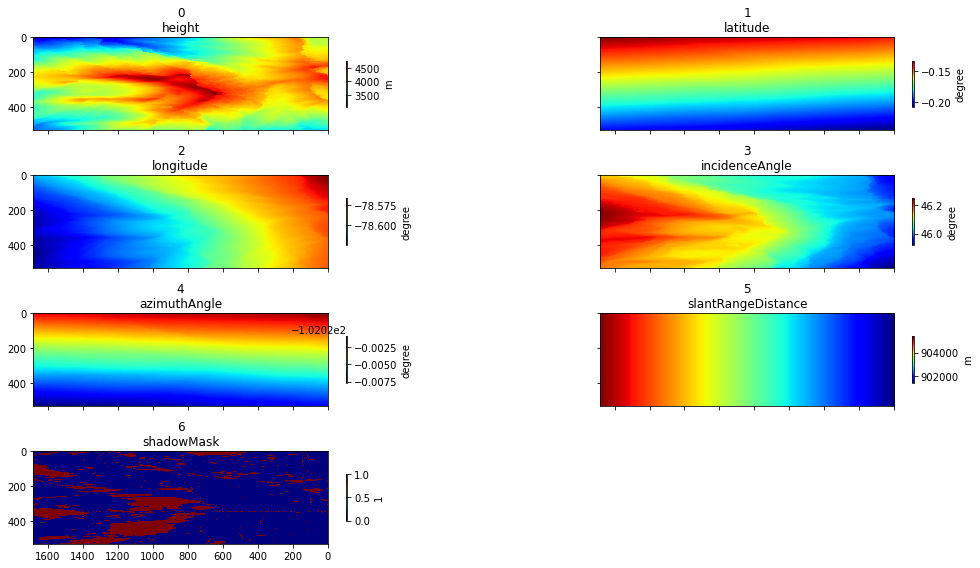

In [49]:
view.main('./minopy/inputs/geometryRadar.h5'.split())

### 2.2 Phase inversion ###

This step runs the phase linking using wrapped phase series. following are the options used for this step. Phase linking methods supported by MiNoPy are **EVD** ([Fornaro et al., 2015](https://ieeexplore.ieee.org/document/6912985), **EMI** ([Ansari et al., 2018](https://ieeexplore.ieee.org/document/8365087)) and **PTA** ([Ferretti et al., 2011](https://ieeexplore.ieee.org/abstract/document/5765671)). All of them can be run in sequential mode **(sequential_EVD, sequential_EMI and sequential_PTA)** ([Ansari et al., 2017](https://ieeexplore.ieee.org/document/8024151)). 

For sequential mode, you can set the number of images as ministack by `minopy.inversion.ministackSize`. Range and azimuth window are the size of searching window to find statistical homogeneous pixels (SHPs). Shp test is the statistical test to find SHPs and three tests supported by MiNoPy including **KS** ([Stephens, 1970](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1970.tb00821.x)), **AD** ([Scholz & Stephens, 1987](https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478517)) and **ttest** ([Derrick et al., 2017](https://www.tqmp.org/RegularArticles/vol13-2/p120/)).

This step supports parallel processing by dividing the subset area into patches. you can set the number of parallel jobs (no more than available CPUs) using `minopy.compute.numWorker` and the patch size by `minopy.inversion.patchSize `. 

Depending on the number of parallel jobs, number of images, the processing method and the subset area (number of patches), the processing time varies. For one patch of `200*200` pixels and 46 images, processing time is 400 seconds (6 min) with a 2.8 GHz processor. 


```cfg
########## 2. parallel job setting
minopy.compute.numWorker              = auto    # auto for 4

########## 4. Divide the area into patches and do phase inversion
## window sizes are used in step 2, 3,
minopy.inversion.patchSize                = auto   # patch size to divide the image for parallel processing, auto for 200
minopy.inversion.ministackSize            = auto   # number of images in each ministack, auto for 10
minopy.inversion.rangeWindow              = auto   # range window size for synthetic multilook, auto for 19
minopy.inversion.azimuthWindow            = auto   # azimuth window size for synthetic multilook, auto for 7
minopy.inversion.shpTest                  = auto   # [ks, ad, ttest] auto for ks: kolmogorov-smirnov test
minopy.inversion.phaseLinkingMethod       = auto   # [EVD, EMI, PTA, sequential_EVD, sequential_EMI, sequential_PTA], auto for sequential_EMI
```


Either run:
```
minopyApp.py PichinchaSenDT142.template --dostep inversion --dir ./minopy
```
or run the commands in run_02_minopy_inversion


In [50]:
!minopyApp.py PichinchaSenDT142.template --dostep inversion --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-13 09:52:24.972554--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['inversion']
Remaining steps: ['ifgram', 'unwrap', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210813:095224 * minopyApp.py PichinchaSenDT142.template --dostep inversion --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy sma

--------------------------------------------------
unpatch block 8/27 : [1600    0 1685  200]
--------------------------------------------------
unpatch block 9/27 : [  0 200 200 400]
--------------------------------------------------
unpatch block 10/27 : [200 200 400 400]
--------------------------------------------------
unpatch block 11/27 : [400 200 600 400]
--------------------------------------------------
unpatch block 12/27 : [600 200 800 400]
--------------------------------------------------
unpatch block 13/27 : [ 800  200 1000  400]
--------------------------------------------------
unpatch block 14/27 : [1000  200 1200  400]
--------------------------------------------------
unpatch block 15/27 : [1200  200 1400  400]
--------------------------------------------------
unpatch block 16/27 : [1400  200 1600  400]
--------------------------------------------------
unpatch block 17/27 : [1600  200 1685  400]
--------------------------------------------------
unpatch block 18/

So far we have inverted the wrapped phase series with sequential_EMI phase linking method and we have the single reference interferograms saved in HDF5 format. The interferograms then need to be unwrapped and converted to displacement time series.

view.py ./minopy/inverted/quality -c gray --notick --noaxis --noverbose


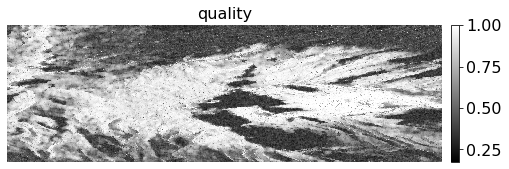

view.py ./minopy/shp -c gray --notick --noaxis --noverbose


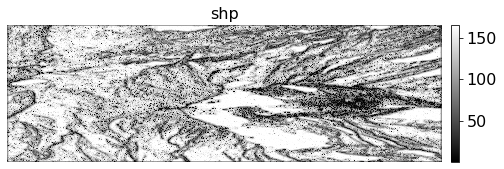

In [56]:
view.main('./minopy/inverted/quality -c gray --notick --noaxis --noverbose'.split())
view.main('./minopy/shp -c gray --notick --noaxis --noverbose'.split())

run view.py in MintPy release version v1.3.0-77, release date 2021-07-24
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/phase_series.h5 in float32 format
file size in y/x: (530, 1685)
input dataset: "['phase']"
num of datasets in file phase_series.h5: 94
datasets to exclude (0):
[]
datasets to display (46):
['phase-1', 'phase-2', 'phase-3', 'phase-4', 'phase-5', 'phase-6', 'phase-7', 'phase-8', 'phase-9', 'phase-10', 'phase-11', 'phase-12', 'phase-13', 'phase-14', 'phase-15', 'phase-16', 'phase-17', 'phase-18', 'phase-19', 'phase-20', 'phase-21', 'phase-22', 'phase-23', 'phase-24', 'phase-25', 'phase-26', 'phase-27', 'phase-28', 'phase-29', 'phase-30', 'phase-31', 'phase-32', 'phase-33', 'phase-34', 'phase-35', 'phase-36', 'phase-37', 'phase-38', 'phase-39', 'phase-40', 'phase-41', 'phase-42', 'phase-43', 'phase-44', 'phase-45', 'phase-46']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/

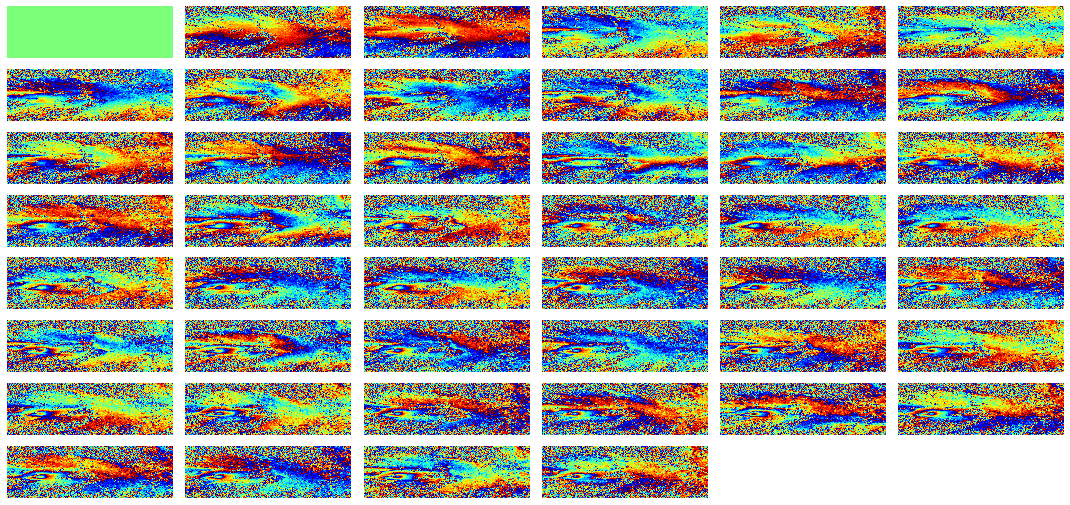

In [54]:
view.main('./minopy/inverted/phase_series.h5 phase --noaxis --nowhitespace'.split())

### 2.3 Select pairs to unwrap ###

Unwrapping is a tedius and difficult task. Since you are working in full resolution and for long temporal baselines, you may have low spatial coherence. So in MiNoPy, you can select a network of minimum interferograms to unwrap and then convert phase to range changes.

For that, there are three options for which pairs to unwrap (following options in template). We use the single reference pairs for this example.
The filter strength has been set to 0 by default but you may do additional filtering at this step.

```cfg
########## 5. Select the interferograms to unwrap
## Different pairs of interferograms can be choosed for unwrapping.
## Following is a short description of each type and the MintPy unwrapping error correction that is valid for them
## 1. mini_stacks: It unwraps single reference interferograms in each ministack. Only bridging for unwrap error correction
## 2. single_reference: It unwraps the single reference interferograms of the whole stack using referenceDate. Only bridging for unwrap error correction
## 2. Short_baselines: A network of short temporal and spatial baselines. Both bridging and phase_closure can be used.
## You may also unwrap certain combination of pairs by giving them in a text file as minopy.interferograms.list
minopy.interferograms.type               = auto     # [mini_stacks, single_reference, short_baselines] default: mini_stacks
minopy.interferograms.list               = auto     # auto for None, list of interferograms to unwrap in a text file
minopy.interferograms.referenceDate      = auto     # auto for the middle image
minopy.interferograms.filterStrength     = auto     # [0-1], auto for 0
```

**The network for single reference pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_single_reference.png">
</p>     

**Mini stack pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_mini_stacks.png">
</p>     

**Short baseline pairs:**

<p align="left">
  <img width="600" src="figures/unwrap_network_short_baselines.png">
</p>     


In [14]:
!minopyApp.py PichinchaSenDT142.template --dostep ifgram --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 09:59:16.385411--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['ifgram']
Remaining steps: ['unwrap', 'load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:095916 * minopyApp.py PichinchaSenDT142.template --dostep ifgram --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cf

line:   224GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160525/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/fine.int.vrt
line:   224API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160724/fine.int.vrt
array width, height, offset:  1685   530     0
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160525/filt_fine.int
line:   256API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_2


 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

**

line:   192GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/fine.int.vrt
line:   160API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.int
line:   224array width, height, offset:  1685   530     0
line:   224GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160910/fine.int.vrt
line:   288GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161109/fine.int.vrt
line:    64API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160910/filt_fine.int
array width, height, offset:  1685   530     0
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161109/filt_fine.int
line:     0GDAL open (R): /Users/


 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines

line:    96GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170315/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170315/fine.int.vrt
line:   128GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170327/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT1

line:   492API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.cor
line:   375
line:   503 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
line:   404 wisdomFile, length =            0
line:   405
 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530
line:   459
line:   406 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:  GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/fine.int.

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170514/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170514/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170514/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170514/filt_fine.int
array width, height, offset:  1685   530     0
line:    32GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170725/fine.int.vrt
API open 


 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0
line:   529GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.int.vrt

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
API open (WR): /Users/Sara/data/test/Pichinc

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170923/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170923/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.int
array width, height, offset:  1685   530     0
line:     0GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170806/fine.int.vrt
GDAL clos

line:   188
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:   315
 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530
line:   340
line:   449 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530


line:   449GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/fine.int.vrt
line:   452API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/filt_fine.int
line:   473
 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530
line:   492GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170911/fine.int.vrt
line:   498API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170911/filt_fine.int
line:   433GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/filt_fine.int.vrt
line:   516API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/filt_fine.cor
line:   527


line:   525GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.int
line:   529GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171029/filt_fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171017/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171017/filt_fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171029/filt_fine.cor

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in o

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.int
array width, height, offset:  1685   530     0
line:     0GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/fine.int.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171216/fine.int.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171110/fine.int.vrt
GDAL open


 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

*** Normal Completion  ***

GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/minopy/i

In [15]:
!ls -l ./minopy/inverted

total 720952
drwxrwxr-x  29 Sara  staff        928 Aug 13 09:52 PATCHES
drwxrwxr-x  47 Sara  staff       1504 Aug 13 11:33 interferograms_single_reference
-rw-rw-r--   1 Sara  staff     893050 Aug 14 09:59 mask_unwrap
-rw-rw-r--   1 Sara  staff       1658 Aug 14 09:59 mask_unwrap.rsc
-rw-rw-r--   1 Sara  staff  360356648 Aug 13 10:08 phase_series.h5
-rw-rw-r--   1 Sara  staff    3572200 Aug 13 10:08 quality
-rw-rw-r--   1 Sara  staff        375 Aug 13 10:08 quality.vrt
-rw-rw-r--   1 Sara  staff       3830 Aug 13 10:08 quality.xml
-rw-rw-r--   1 Sara  staff    3572200 Aug 14 09:59 quality_msk
-rw-rw-r--   1 Sara  staff        749 Aug 14 09:59 quality_msk.rsc


### 2.4 Unwrap interferograms ###

For this step you may use your own unwrapping software. MiNoPy uses [SNAPHU](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/) and you can set the following parameters for unwrapping. If you have a mask in HDF5 format like `waterMask.h5`, you can use it by `minopy.unwrap.mask`

```cfg
########## 6. Unwrap parameters
minopy.unwrap.maxDiscontinuity           = auto     # (snaphu parameter) max phase discontinuity in cycle, auto for 1.2
minopy.unwrap.initMethod                 = auto     # [MCF, MST] auto for MCF
minopy.unwrap.mask                       = auto     # auto for None
```

Furthermore, if you want to set mote [parameters](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/snaphu.conf.full) from snaphu, you can add them in `conf.full` in your minopy directory (PichinchaSenDT142/minopy/conf.full). MiNoPy will unwrap in tile mode if your subset area is large. Following you will find the parameters set by default:


In [67]:
!cat ./minopy/conf.full

INITMETHOD	MCF
INFILEFORMAT   COMPLEX_DATA
OUTFILEFORMAT	ALT_LINE_DATA
CORRFILEFORMAT	FLOAT_DATA
MINCONNCOMPFRAC 	0.001
SINGLETILEREOPTIMIZE   FALSE
STATCOSTMODE  DEFO
RMTMPTILE 	   TRUE
MAXNCOMPS       50


In [24]:
!minopyApp.py PichinchaSenDT142.template --dostep unwrap --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 10:33:28.953836--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['unwrap']
Remaining steps: ['load_ifgram', 'correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:103328 * minopyApp.py PichinchaSenDT142.template --dostep unwrap --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cfg to input

b'only one tile--disregarding tile overlap values\n'
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw.conncomp.vrt
Time spent: 1.1828452150026958 m
b'only one tile--disregarding tile overlap values\n'
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.unw.vrt
GDAL open (R): /Us

b'only one tile--disregarding tile overlap values\n'
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.unw.conncomp.vrt
Time spent: 1.0790235201517742 m
b'only one tile--disregarding tile overlap values\n'
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160817/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160817/filt_fine.unw.vrt
GDAL open (R): /Us

2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170420/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161209/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170303/fi

20210814:103705 * unwrap_minopy.py --ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170502/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/quality_msk --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170502/filt_fine.unw --max_discontinuity 1.2 --init_method MCF --length 530 --width 1685 --height 698882.4836057822 --num_tiles 1 --earth_radius 6337298.410627297 --wavelength 0.05546576 -m /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/mask_unwrap
20210814:103705 * unwrap_minopy.py --ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170701/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/quality_msk --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170701/filt_fine.unw --max_dis

GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.unw.conncomp.vrt
Time spent: 0.998988135655721 m
b'only one tile--disregarding tile overlap values\n'
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.conncomp.vrt
Time spent: 1.0584564646085104 m
b'only one tile--disr

2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170818/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170806/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170806/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20170806/filt_fine.unw
2
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/config_all -d /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171005/fi

20210814:103925 * unwrap_minopy.py --ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/quality_msk --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.unw --max_discontinuity 1.2 --init_method MCF --length 530 --width 1685 --height 698882.4836057822 --num_tiles 1 --earth_radius 6337298.410627297 --wavelength 0.05546576 -m /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/mask_unwrap
20210814:103925 * unwrap_minopy.py --ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171204/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/quality_msk --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20171204/filt_fine.unw --max_dis

Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/minopy

###############################################################
Normal end of Non-Linear time series processing workflow!
##############################################################
Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/minopy

################################################
   Normal end of minopyApp processing!
################################################
Time used: 06 mins 45.7 secs



### 2.5 Load interferograms in a stack (MintPy format) ###

In this step you will load unwrapped interferograms to `./minopy/inputs/ifgramStack.h5`, MintPy format.
The available options are:
```cfg
##---------interferogram datasets:
minopy.load.unwFile        = auto  #[path2unw_file]
minopy.load.corFile        = auto  #[path2cor_file]
minopy.load.connCompFile   = auto  #[path2conn_file], optional
minopy.load.intFile        = auto  #[path2int_file], optional
minopy.load.ionoFile       = auto  #[path2iono_file], optional
```

In [26]:
!minopyApp.py PichinchaSenDT142.template --dostep load_ifgram --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 10:43:04.923795--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_ifgram']
Remaining steps: ['correct_unwrap_error', 'phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:104304 * minopyApp.py PichinchaSenDT142.template --dostep load_ifgram --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   d

In [27]:
!ls -l ./minopy/inputs

total 1398592
-rw-r--r--   1 Sara  staff       1798 Aug 14 10:29 PichinchaSenDT142.template
drwxr-xr-x  53 Sara  staff       1696 Jul 19 16:12 baselines
-rw-rw-r--   1 Sara  staff        413 Aug 14 10:43 date_list.txt
-rw-rw-r--   1 Sara  staff   12214433 Aug 14 10:42 geometryRadar.h5
-rw-rw-r--   1 Sara  staff  334244418 Aug 14 10:43 ifgramStack.h5
-rw-rw-r--   1 Sara  staff       5384 Aug 14 10:43 minopyApp.cfg
drwxr-xr-x   5 Sara  staff        160 Aug 12 11:29 reference
-rw-rw-r--   1 Sara  staff  354537608 Aug 13 09:46 slcStack.h5
-rw-rw-r--   1 Sara  staff      20527 Aug 13 09:45 smallbaselineApp.cfg


### 2.6 Correct unwrapping error (using MintPy) ###

This step uses one of unwrapping error corrections of MintPy depending on the network of unwrapped interferograms.
There are two methods of `bridging` and `phase_closure` or both of them to use. For a full description of the methods, refer to ([Y. Zhang et al., 2019](https://www.sciencedirect.com/science/article/pii/S0098300419304194?via%3Dihub)). If you unwrapped the `short_baselines` network, you can use both methods otherwise use bridging.
You can set following parameters from smallbaselineApp.cfg:

```cfg
########## correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure          - suitable for highly redundant network
## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
mintpy.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]

## phase_closure options:
## numSample - a region-based strategy is implemented to speedup L1-norm regularized least squares inversion.
##     Instead of inverting every pixel for the integer ambiguity, a common connected component mask is generated,
##     for each common conn. comp., numSample pixels are radomly selected for inversion, and the median value of the results
##     are used for all pixels within this common conn. comp.
mintpy.unwrapError.numSample       = auto  #[int>1], auto for 100, number of samples to invert for common conn. comp.

## briding options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##     before estimating the phase difference between reliable regions and added back after the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
```


**This step includes setting reference point and generating `avgSpatialCoh.h5` as by-products and you need to run it even if `mintpy.unwrapError.method` is set to `no`.**



In [38]:
!minopyApp.py PichinchaSenDT142.template --dostep correct_unwrap_error --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 11:10:06.956672--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['correct_unwrap_error']
Remaining steps: ['phase_to_range', 'mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:111006 * minopyApp.py PichinchaSenDT142.template --dostep correct_unwrap_error --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
    mintpy.unwrapError.method: auto --> bridging
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy PichinchaSenDT142.template to pic      d

input  dataset: unwrapPhase
output dataset: unwrapPhase_bridging
create /unwrapPhase_bridging of np.float32 in size of (45, 530, 1685)
[==================================================] 20170408_20171228    7s /     0s
close /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5 file.
add/update the following configuration metadata to file:
mintpy.unwrapError.bridgePtsRadius = 50

time used: 00 mins 8.1 secs
Done.

******************** plot & save to pic ********************
parallel processing using 8 cores ...
view.py --dpi 150 --noverbose --nodisplay --update inputs/geometryRadar.h5
view.py --dpi 150 --noverbose --nodisplay --update maskTempCoh.h5 -c gray -v 0 1
view.py --dpi 150 --noverbose --nodisplay --update temporalCoherence.h5 -c gray -v 0 1
view.py --dpi 150 --noverbose --nodisplay --update inputs/ifgramStack.h5 unwrapPhase- --zero-mask --wrap -c cmy
view.py --dpi 150 --noverbose --nodisplay --update inputs/ifgramStack.h5 unwrapPhase- --zero-mask
view.py --dpi

In [57]:
!info.py ./minopy/inputs/ifgramStack.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/minopy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                  1
  ANTENNA_SIDE                            -1
  AZIMUTH_PIXEL_SIZE                      15.61631188914008
  CENTER_INCIDENCE_ANGLE                  46.153805
  CENTER_LINE_UTC                         39141.0
  DATA_TYPE                               float32
  DATE12                                  170408-160419
  EARTH_RADIUS                            6337298.410627297
  FILE_LENGTH                             530
  FILE_PATH                               /Users/Sara/data/test/PichinchaSenDT142/minopy/inverted/interferograms_single_reference/20170408_20160419/filt_fine.unw
  FILE_TYPE                               ifgramStack
  HEADING                                 -167.968

### 2.7 Convert phase to range change time series ###

At this step you convert the `ifgramStack.h5` to `timeseries.h5` using minimum-norm deformation phase. water mask and threshold for temporal coherence can be set with these options:

```cfg
########## 7. Convert Phase to Range
minopy.timeseries.minTempCoh             = auto     # auto for 0.5
minopy.timeseries.waterMask              = auto     # auto for None

```

In [48]:
!minopyApp.py PichinchaSenDT142.template --dostep phase_to_range --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 11:18:47.942398--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['phase_to_range']
Remaining steps: ['mintpy_corrections']
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:111847 * minopyApp.py PichinchaSenDT142.template --dostep phase_to_range --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy PichinchaS

close HDF5 file timeseries.h5.
--------------------------------------------------
open  HDF5 file temporalCoherence.h5 in a mode
writing dataset /temporalCoherence         block: [0, 530, 0, 1685]
close HDF5 file temporalCoherence.h5.
--------------------------------------------------
open  HDF5 file numInvIfgram.h5 in a mode
writing dataset /mask                      block: [0, 530, 0, 1685]
close HDF5 file numInvIfgram.h5.
--------------------------------------------------
update values on the reference pixel: (328, 449)
set temporalCoherence on the reference pixel to 1.
set  # of observations on the reference pixel as 45
generate_mask.py /Users/Sara/data/test/PichinchaSenDT142/minopy/temporalCoherence.h5 -m 0.5 --nonzero -o /Users/Sara/data/test/PichinchaSenDT142/minopy/maskTempCoh.h5 --update
update mode: ON
run or skip: run
input temporalCoherence file: /Users/Sara/data/test/PichinchaSenDT142/minopy/temporalCoherence.h5
read /Users/Sara/data/test/PichinchaSenDT142/minopy/temporalC

run view.py in MintPy release version v1.3.0-77, release date 2021-07-24
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 'timeseries-20170619', 

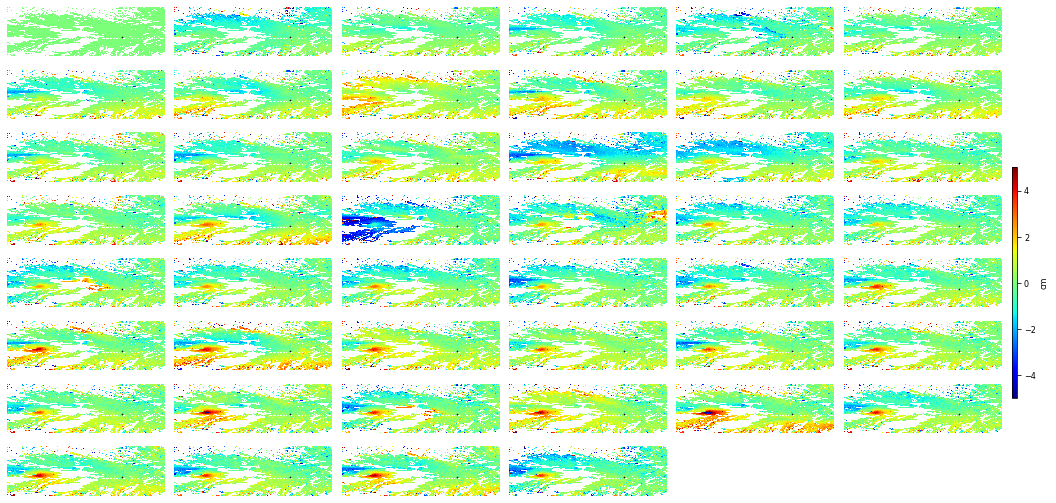

In [49]:
view.main('./minopy/timeseries.h5 --wrap --wrap-range -5 5 -u cm --notitle --notick --noaxis'.split())

### 2.8 MintPy Corrections (time series analysis) ###

This step would apply different timeseries corrections from MintPy. Since the outputs are in the same format as MintPy, you can switch on any of the correction methods. In fact you can use smallbaselineApp.py instead and run the steps after `correct_LOD`. 

Run `smallbaselineApp.py -h` for more help on the correction steps.

For this example we would only correct for topographic phase residuals and all others are set to `no` in the template file.

In [50]:
!minopyApp.py PichinchaSenDT142.template --dostep mintpy_corrections --dir ./minopy

--------------------------------------------------
MiNoPy release version V0.1.0-alpha, release date 2021-08-11
--RUN-at-2021-08-14 11:19:13.435002--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['mintpy_corrections']
Remaining steps: []
Project name: PichinchaSenDT142
--------------------------------------------------
20210814:111913 * minopyApp.py PichinchaSenDT142.template --dostep mintpy_corrections --dir ./minopy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/minopy
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.template
update default template based on input custom template
No new option value found, skip updating /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg
copy PichinchaSenDT142.template to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy PichinchaSenDT142.temp

read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with ZERO in ALL acquisitions
read mean bperp from timeseries file
skip pixels with ZERO in ALL acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with NaN  in ANY acquisitions
skip pixels with ZERO temporal coherence
skip pixels with NaN  in ANY acquisitions

time used: 00 mins 3.3 secs.


******************** step - velocity ********************

timeseries2velocity.py /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries_demErr.h5 -t /Users/Sara/data/test/PichinchaSenDT142/minopy/smallbaselineApp.cfg -o /Users/Sara/data/test/PichinchaSenDT142/minopy/velocity.h5 --update
read options from template file: smallbaselineApp.cfg
open timeseries file: timeseries_demErr.h5
--------------------------------------------------
dates from input file: 46
['20160419', '20160501', '20160513', '20160525', '20160606', '20160630', '20160724', '20160805', '20160817', '20160829', '20160910', '20160922', '20161016', '20161022', '20161109', '20161115', '20161209', '20170102', '20170126', '20170219', '20170303', '20170315', '20170327', '20170408', '20170420', '20170502', '20170514', '20170526', '20170607', '20170619', '20170701', '20170713', '20170725', '20170806', '20170818', '20170830', '20170911', '20170923', '20171005', '20171017', '20171029', '20171110'

input temporalCoherence file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_temporalCoherence.h5
read /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_temporalCoherence.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.7
exclude pixels in base file geo_geometryRadar.h5 dataset shadowMask with value == 1.0
delete exsited file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_maskTempCoh.h5
create HDF5 file: /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (530, 1685)          with compression=None
finished writing to /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_maskTempCoh.h5
time used: 00 mins 0.2 secs.


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

save_kmz.py /Users/Sara/data/test/PichinchaSenDT142/minopy/geo/geo_ve

view.py ./minopy/temporalCoherence.h5 -c gray --notick --noaxis --noverbose


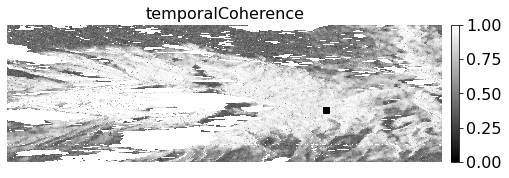

view.py ./minopy/maskTempCoh.h5 -c gray --notick --noaxis --noverbose


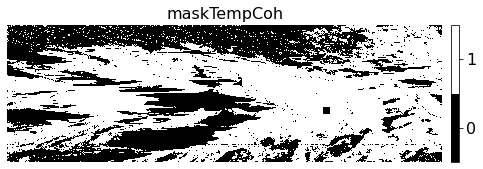

In [51]:
view.main('./minopy/temporalCoherence.h5 -c gray --notick --noaxis --noverbose'.split())
view.main('./minopy/maskTempCoh.h5 -c gray --notick --noaxis --noverbose'.split())

run view.py in MintPy release version v1.3.0-77, release date 2021-07-24
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/minopy/timeseries_demErr.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries_demErr.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 'timeseri

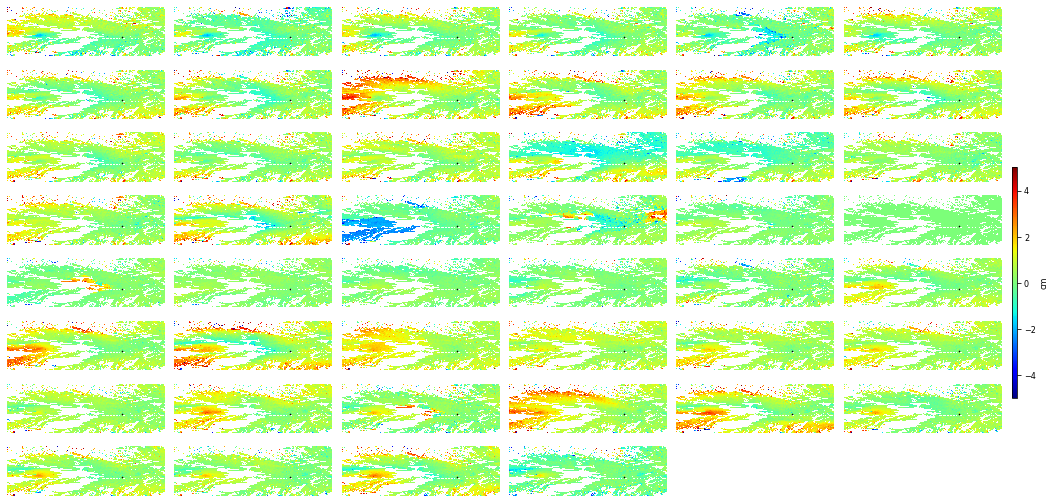

In [58]:
view.main('./minopy/timeseries_demErr.h5 --wrap --wrap-range -5 5 --notitle --notick --noaxis'.split())

view.py ./minopy/velocity.h5 velocity --notick --noaxis --noverbose


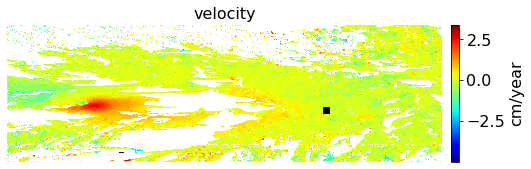

In [60]:
view.main('./minopy/velocity.h5 velocity --notick --noaxis --noverbose'.split())

In [61]:
!ls -l ./minopy/geo

total 440344
-rw-rw-r--  1 Sara  staff    3704104 Aug 14 11:05 geo_avgSpatialCoh.h5
-rw-rw-r--  1 Sara  staff   23031392 Aug 14 11:05 geo_geometryRadar.h5
-rw-rw-r--  1 Sara  staff     929096 Aug 14 11:20 geo_maskTempCoh.h5
-rw-rw-r--  1 Sara  staff    3705288 Aug 14 11:20 geo_temporalCoherence.h5
-rw-rw-r--  1 Sara  staff  176531720 Aug 14 11:20 geo_timeseries_demErr.h5
-rw-rw-r--  1 Sara  staff    7390072 Aug 14 11:20 geo_velocity.h5


view.py ./minopy/geo/geo_velocity.h5 velocity --dem ./minopy/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose


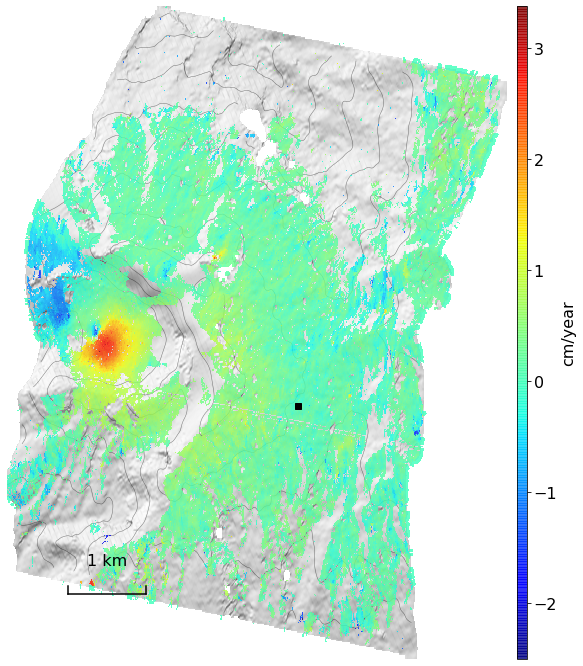

In [63]:
view.main('./minopy/geo/geo_velocity.h5 velocity --dem ./minopy/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose'.split())


## 3. Correct for geolocation ##

Working in full resolution, required preceise geolocation specially in urban areas. 
This is a separate post processing step you may want to perform.

After topographic residual correction step of MintPy, There is `demErr.h5` as a by-product. You can use it as bellow to correct the geo coordinates stored in `./minopy/inputs/geometryRadar.h5`. 

```
correct_geolocation.py -g ./minopy/inputs/geometryRadar.h5 -d ./minopy/demErr.h5
```

**Remember: This correction is in radar coordinate and you need to run it before geocode step in MintPy, or run the geocoding again:**

```
smallbaselineApp.py PichinchaSenDT142.template --dir ./minopy --start geocode
```